# PyTorch Training and using checkpointing on SageMaker Managed Spot Training
The example here is almost the same as [PyTorch Cifar10 local training](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/pytorch_cnn_cifar10/pytorch_local_mode_cifar10.ipynb).

This notebook tackles the exact same problem with the same solution, but it has been modified to be able to run using SageMaker Managed Spot infrastructure. SageMaker Managed Spot uses [EC2 Spot Instances](https://aws.amazon.com/ec2/spot/) to run Training at a lower cost.

Please read the original notebook and try it out to gain an understanding of the ML use-case and how it is being solved. We will not delve into that here in this notebook.

## Overview

The **SageMaker Python SDK** helps you deploy your models for training and hosting in optimized, productions ready containers in SageMaker. The SageMaker Python SDK is easy to use, modular, extensible and compatible with TensorFlow, MXNet, PyTorch and Chainer. This tutorial focuses on how to create a convolutional neural network model to train the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) using **PyTorch in local mode**.

### Set up the environment

This notebook was created and tested on a single `ml.p2.xlarge` notebook instance.

Note: I used `ml.g4dn.xlarge`

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).

In [2]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('SageMaker version: ' + sagemaker.__version__)

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10'

role = sagemaker.get_execution_role()
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket, checkpoint_suffix)

print('Checkpointing Path: {}'.format(checkpoint_s3_path))

SageMaker version: 2.154.0
Checkpointing Path: s3://sagemaker-us-west-2-075912829265/checkpoint-0d4a68fa


In [3]:
import os
import subprocess

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print("Instance type = " + instance_type)

Thu Oct 12 13:23:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%writefile -a utils_cifar.py
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def _get_transform():
    return transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    

def get_train_data_loader():
    transform = _get_transform()
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    return torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

    
def get_test_data_loader():
    transform = _get_transform()
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
    return torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
    

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

--2023-10-12 13:25:14--  https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-managed-spot-training/main/pytorch_managed_spot_training_checkpointing/utils_cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1222 (1.2K) [text/plain]
Saving to: ‘utils_cifar.py’

utils_cifar.py      100%[===================>]   1.19K  --.-KB/s    in 0s      

2023-10-12 13:25:14 (51.0 MB/s) - ‘utils_cifar.py’ saved [1222/1222]



### Download the Cifar10 dataset

In [5]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

100%|██████████| 170498071/170498071 [00:06<00:00, 27570222.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Data Preview

      dog     truck       car       cat


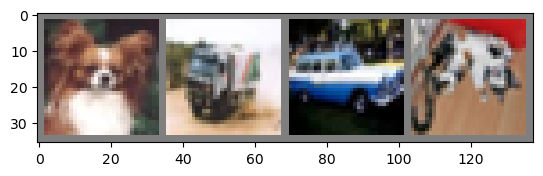

In [7]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)

images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

### Upload the data
We use the ```sagemaker.Session.upload_data``` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use this later when we start the training job.

In [8]:
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix='data/cifar10')

# Construct a script for training 
Here is the full code for the network model:

In [9]:
!mkdir ./source_dir

In [10]:
%%writefile -a ./source_dir/cifar10.py
import argparse
import logging
import time
import json
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms
import torch.nn.functional as F

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py#L118
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def _train(args):
    is_distributed = len(args.hosts) > 1 and args.dist_backend is not None
    logger.debug("Distributed training - {}".format(is_distributed))

    if os.path.isdir(args.checkpoint_path):
        print("Checkpointing directory {} exists".format(args.checkpoint_path))
    else:
        print("Creating Checkpointing directory {}".format(args.checkpoint_path))
        os.mkdir(args.checkpoint_path)
    
    if is_distributed:
        # Initialize the distributed environment.
        world_size = len(args.hosts)
        os.environ['WORLD_SIZE'] = str(world_size)
        host_rank = args.hosts.index(args.current_host)
        os.environ['RANK'] = str(host_rank)
        dist.init_process_group(backend=args.dist_backend, rank=host_rank, world_size=world_size)
        print(
            'Initialized the distributed environment: \'{}\' backend on {} nodes. '.format(
                args.dist_backend,
                dist.get_world_size()) + 'Current host rank is {}. Using cuda: {}. Number of gpus: {}'.format(
                dist.get_rank(), torch.cuda.is_available(), args.num_gpus))

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Device Type: {}".format(device))

    print("Loading Cifar10 dataset")
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root=args.data_dir, train=True,
                                            download=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                               shuffle=True, num_workers=args.workers)

    testset = torchvision.datasets.CIFAR10(root=args.data_dir, train=False,
                                           download=False, transform=transform)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                              shuffle=False, num_workers=args.workers)

    print("Model loaded")
    model = Net()

    if torch.cuda.device_count() > 1:
        print("Gpu count: {}".format(torch.cuda.device_count()))
        model = nn.DataParallel(model)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    # Check if checkpoints exists
    if not os.path.isfile(args.checkpoint_path + '/checkpoint.pth'):
        epoch_number = 0
    else:    
        model, optimizer, epoch_number = _load_checkpoint(model, optimizer, args)        
    
    for epoch in range(epoch_number, args.epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            
        _save_checkpoint(model, optimizer, epoch, loss, args)
            
    print('Finished Training')
    return _save_model(model, args.model_dir)


def _save_model(model, model_dir):
    print("Saving the model.")
    path = os.path.join(model_dir, 'model.pth')
    # recommended way from http://pytorch.org/docs/master/notes/serialization.html
    torch.save(model.cpu().state_dict(), path)


def _save_checkpoint(model, optimizer, epoch, loss, args):
    print("epoch: {} - loss: {}".format(epoch+1, loss))
    checkpointing_path = args.checkpoint_path + '/checkpoint.pth'
    print("Saving the Checkpoint: {}".format(checkpointing_path))
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, checkpointing_path)

    
def _load_checkpoint(model, optimizer, args):
    print("--------------------------------------------")
    print("Checkpoint file found!")
    print("Loading Checkpoint From: {}".format(args.checkpoint_path + '/checkpoint.pth'))
    checkpoint = torch.load(args.checkpoint_path + '/checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_number = checkpoint['epoch']
    loss = checkpoint['loss']
    print("Checkpoint File Loaded - epoch_number: {} - loss: {}".format(epoch_number, loss))
    print('Resuming training from epoch: {}'.format(epoch_number+1))
    print("--------------------------------------------")
    return model, optimizer, epoch_number

    
def model_fn(model_dir):
    print('model_fn')
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Net()
    if torch.cuda.device_count() > 1:
        print("Gpu count: {}".format(torch.cuda.device_count()))
        model = nn.DataParallel(model)

    with open(os.path.join(model_dir, 'model.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f))
    return model.to(device)


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument('--workers', type=int, default=2, metavar='W',
                        help='number of data loading workers (default: 2)')
    parser.add_argument('--epochs', type=int, default=2, metavar='E',
                        help='number of total epochs to run (default: 2)')
    parser.add_argument('--batch_size', type=int, default=4, metavar='BS',
                        help='batch size (default: 4)')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='initial learning rate (default: 0.001)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M', help='momentum (default: 0.9)')
    parser.add_argument('--dist_backend', type=str, default='gloo', help='distributed backend (default: gloo)')

    parser.add_argument('--hosts', type=list, default=json.loads(os.environ['SM_HOSTS']))
    parser.add_argument('--current-host', type=str, default=os.environ['SM_CURRENT_HOST'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--data-dir', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument("--checkpoint-path",type=str,default="/opt/ml/checkpoints")
    parser.add_argument('--num-gpus', type=int, default=os.environ['SM_NUM_GPUS'])

    _train(parser.parse_args())

Writing ./source_dir/cifar10.py


In [11]:
!pygmentize source_dir/cifar10.py

import argparse
import logging
import time
import json
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms
import torch.nn.functional as F

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py#L118
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(s

## Script Functions

SageMaker invokes the main function defined within your training script for training. When deploying your trained model to an endpoint, the model_fn() is called to determine how to load your trained model. The model_fn() along with a few other functions list below are called to enable predictions on SageMaker.

### [Predicting Functions](https://github.com/aws/sagemaker-pytorch-containers/blob/master/src/sagemaker_pytorch_container/serving.py)
* model_fn(model_dir) - loads your model.
* input_fn(serialized_input_data, content_type) - deserializes predictions to predict_fn.
* output_fn(prediction_output, accept) - serializes predictions from predict_fn.
* predict_fn(input_data, model) - calls a model on data deserialized in input_fn.

The model_fn() is the only function that doesn't have a default implementation and is required by the user for using PyTorch on SageMaker. 

## Create a training job using the sagemaker.PyTorch estimator

The `PyTorch` class allows us to run our training function on SageMaker. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. For local training with GPU, we could set this to "local_gpu".  In this case, `instance_type` was set above based on your whether you're running a GPU instance.

After we've constructed our `PyTorch` object, we fit it using the data we uploaded to S3. Even though we're in local mode, using S3 as our data source makes sense because it maintains consistency with how SageMaker's distributed, managed training ingests data.


In [16]:
!yum update -q

/usr/bin/sh: 1: yum: not found


In [15]:
!apt-get install docker-compose-plugin

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package docker-compose-plugin


In [17]:
from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 2}

cifar10_estimator = PyTorch(entry_point='source_dir/cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            hyperparameters=hyperparameters,
                            instance_count=1,
                            instance_type=instance_type)

cifar10_estimator.fit(inputs)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-10-12-13-37-38-406


ImportError: 'docker-compose' is not installed. Local Mode features will not work without docker-compose. For more information on how to install 'docker-compose', please, see https://docs.docker.com/compose/install/

## Run a baseline training job on SageMaker

Now we run training jobs on SageMaker, starting with our baseline training job.

Once again, we create a PyTorch estimator, with a couple key modfications from last time:

* `instance_type`: the instance type for training. We set this to `ml.p3.2xlarge` because we are training on SageMaker now. For a list of available instance types, see [the AWS documentation](https://aws.amazon.com/sagemaker/pricing/instance-types).
* `metric_definitions`: the metrics (defined above) that we want sent to CloudWatch.

In [18]:
from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 10}

cifar10_estimator = PyTorch(entry_point='source_dir/cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            hyperparameters=hyperparameters,
                            instance_count=1,
                            instance_type='ml.p3.2xlarge',
                            base_job_name='cifar10-pytorch')

cifar10_estimator.fit(inputs)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: cifar10-pytorch-2023-10-12-13-38-56-260


Using provided s3_resource
2023-10-12 13:38:56 Starting - Starting the training job...
2023-10-12 13:39:22 Starting - Preparing the instances for training.........
2023-10-12 13:40:41 Downloading - Downloading input data...
2023-10-12 13:41:11 Training - Downloading the training image...............
2023-10-12 13:43:57 Training - Training image download completed. Training in progress.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-10-12 13:44:26,955 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-10-12 13:44:26,984 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-10-12 13:44:26,987 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-10-12 13:44:27,278 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {

# Managed Spot Training with a PyTorch Estimator

For Managed Spot Training using a PyTorch Estimator we need to configure two things:
1. Enable the `train_use_spot_instances` constructor arg - a simple self-explanatory boolean.
2. Set the `train_max_wait` constructor arg - this is an int arg representing the amount of time you are willing to wait for Spot infrastructure to become available. Some instance types are harder to get at Spot prices and you may have to wait longer. You are not charged for time spent waiting for Spot infrastructure to become available, you're only charged for actual compute time spent once Spot instances have been successfully procured.

Normally, a third requirement would also be necessary here - modifying your code to ensure a regular checkpointing cadence - however, PyTorch Estimators already do this, so no changes are necessary here. Checkpointing is highly recommended for Manage Spot Training jobs due to the fact that Spot instances can be interrupted with short notice and using checkpoints to resume from the last interruption ensures you don't lose any progress made before the interruption.

Feel free to toggle the `use_spot_instances` variable to see the effect of running the same job using regular (a.k.a. "On Demand") infrastructure.

Note that `max_wait` can be set if and only if `use_spot_instances` is enabled and **must** be greater than or equal to `max_run`.

In [19]:
use_spot_instances = True
max_run=600
max_wait = 1200 if use_spot_instances else None

## Simulating Spot interruption after 5 epochs

Our training job should run on 10 epochs.

However, we will simulate a situation that after 5 epochs a spot interruption occurred.

The goal is that the checkpointing data will be copied to S3, so when there is a spot capacity available again, the training job can resume from the 6th epoch.

Note the `checkpoint_s3_uri` variable which stores the S3 URI in which to persist checkpoints that the algorithm persists (if any) during training.

The `debugger_hook_config` parameter must be set to `False` to enable checkpoints to be copied to S3 successfully.

In [20]:
hyperparameters = {'epochs': 5}


spot_estimator = PyTorch(entry_point='source_dir/cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.p3.2xlarge',
                            base_job_name='cifar10-pytorch-spot-1',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait)

spot_estimator.fit(inputs)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: cifar10-pytorch-spot-1-2023-10-12-13-57-18-935


Using provided s3_resource
2023-10-12 13:57:19 Starting - Starting the training job...
2023-10-12 13:57:45 Starting - Preparing the instances for training............
2023-10-12 13:59:49 Downloading - Downloading input data...
2023-10-12 14:00:19 Training - Downloading the training image..................
2023-10-12 14:03:10 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-10-12 14:03:36,140 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-10-12 14:03:36,171 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-10-12 14:03:36,174 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-10-12 14:03:36,430 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dir

### Savings
Towards the end of the job you should see two lines of output printed:

- `Training seconds: X` : This is the actual compute-time your training job spent
- `Billable seconds: Y` : This is the time you will be billed for after Spot discounting is applied.

If you enabled the `use_spot_instances` var then you should see a notable difference between `X` and `Y` signifying the cost savings you will get for having chosen Managed Spot Training. This should be reflected in an additional line:
- `Managed Spot Training savings: (1-Y/X)*100 %`

### View the job training Checkpoint configuration
We can now view the Checkpoint configuration from the training job directly in the SageMaker console.

Log into the [SageMaker console](https://console.aws.amazon.com/sagemaker/home), choose the latest training job, and scroll down to the Checkpoint configuration section. 

Choose the S3 output path link and you'll be directed to the S3 bucket were checkpointing data is saved.

You can see there is one file there:

```python
checkpoint.pth
```

This is the checkpoint file that contains the epoch, model state dict, optimizer state dict, and loss.

### Continue training after Spot capacity is resumed

Now we simulate a situation where Spot capacity is resumed.

We will start a training job again, this time with 10 epochs.

What we expect is that the tarining job will start from the 6th epoch.

This is done when training job starts. It checks the checkpoint s3 location for checkpoints data. If there are, they are copied to `/opt/ml/checkpoints` on the training conatiner.

In the code you can see the function to load the checkpoints data:

```python
def _load_checkpoint(model, optimizer, args):
    print("--------------------------------------------")
    print("Checkpoint file found!")
    print("Loading Checkpoint From: {}".format(args.checkpoint_path + '/checkpoint.pth'))
    checkpoint = torch.load(args.checkpoint_path + '/checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_number = checkpoint['epoch']
    loss = checkpoint['loss']
    print("Checkpoint File Loaded - epoch_number: {} - loss: {}".format(epoch_number, loss))
    print('Resuming training from epoch: {}'.format(epoch_number+1))
    print("--------------------------------------------")
    return model, optimizer, epoch_number
```


In [ ]:
hyperparameters = {'epochs': 10}


spot_estimator = PyTorch(entry_point='source_dir/cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.p3.2xlarge',
                            base_job_name='cifar10-pytorch-spot-2',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait)

spot_estimator.fit(inputs)

### Analyze training job logs

Analyzing the training job logs, we can see that now, the training job starts from the 6th epoch.

We can see the output of `_load_checkpoint` function:

```
--------------------------------------------
Checkpoint file found!
Loading Checkpoint From: /opt/ml/checkpoints/checkpoint.pth
Checkpoint File Loaded - epoch_number: 5 - loss: 0.8455273509025574
Resuming training from epoch: 6
--------------------------------------------
```

### View the job training Checkpoint configuration after job completed 10 epochs

We can now view the Checkpoint configuration from the training job directly in the SageMaker console.  

Log into the [SageMaker console](https://console.aws.amazon.com/sagemaker/home), choose the latest training job, and scroll down to the Checkpoint configuration section. 

Choose the S3 output path link and you'll be directed to the S3 bucket were checkpointing data is saved.

You can see there is still that one file there:

```python
checkpoint.pth
```

You'll be able to see that the date of the checkpoint file was updated to the time of the 2nd Spot training job.

# Deploy the trained model to prepare for predictions

The deploy() method creates an endpoint which serves prediction requests in real-time.

In [ ]:
from sagemaker.pytorch import PyTorchModel

predictor = spot_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# Invoking the endpoint

In [ ]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print('Predicted: ', ' '.join('%4s' % classes[predicted[j]]
                              for j in range(4)))

# Clean-up

To avoid incurring extra charges to your AWS account, let's delete the endpoint we created:

In [ ]:
predictor.delete_endpoint()